In [4]:
## Get new prepocess format running

In [5]:
from functions import *

In [6]:
models,data, errors=find_data(version='d_easter1')

In [7]:
print(data,errors)

['Realisierter_Stromverbrauch_202402200600_202403020559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402230600_202403050559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402240600_202403060559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402250600_202403070559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402260600_202403080559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402270600_202403090559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402280600_202403100559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402290600_202403110459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403010600_202403120459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403020600_202403130459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403030600_202403140459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403040600_202403150459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403050600_202403160459_Viertelstunde.csv', 'Realisierter_Stromverbr

In [8]:
new_real=pd.read_csv(data[-1],delimiter=';')
old_real=pd.read_csv(data[-10],delimiter=';')

In [8]:
print(new_real.describe())

       VD-DM-Alles.tabellenKopf.columnHeader.date_start  \
count                                              1056   
unique                                             1056   
top                                    09.04.2024 06:00   
freq                                                  1   

       VD-DM-Alles.tabellenKopf.columnHeader.date_end  \
count                                            1056   
unique                                           1056   
top                                  09.04.2024 06:15   
freq                                                1   

       Gesamt (Netzlast) [MWh] Originalauflösungen  \
count                                         1056   
unique                                         894   
top                                              -   
freq                                           145   

       Residuallast [MWh] Originalauflösungen  \
count                                    1056   
unique                                    902   


In [9]:
def prepare_input2(df,pump=False,end=False,bad_cut=0.9,zero_time=(2015,1,1,0,0),old=False,str_convert=True,version='y_fraction1',newest=False):
    #zero time of model can change later
    zero=datetime(zero_time[0],zero_time[1],zero_time[2],zero_time[3],zero_time[4])
    #new column names
    if old==False and newest==False:
        dic2={'Datum':'Date','Anfang':'Time','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power','Residuallast [MWh] Originalauflösungen':'residual_power','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
        df.rename(columns=dic2,inplace=True)
    if old==False and newest==True:
        dic3={'VD-DM-Alles.tabellenKopf.columnHeader.date_start':'date_time','VD-DM-Alles.tabellenKopf.columnHeader.date_end':'date_time_end','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power','Residuallast [MWh] Originalauflösungen':'residual_power','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
        df.rename(columns=dic3,inplace=True)        
    elif old==True:
        dic1={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'}
        df.rename(columns=dic1,inplace=True)
    #drop columns
    if end==True:
        df.drop(['Ende'], axis=1, inplace=True)
    #cpnvert german float to english 
    if str_convert==True:
        df['residual_power'] = df['residual_power'].str.replace('.','')
        df['residual_power'] = df['residual_power'].str.replace('-','0')
        df['residual_power'] = df['residual_power'].str.replace(',','.').astype(float)/1000.
        df['total_power'] = df['total_power'].str.replace('.','')
        df['total_power'] = df['total_power'].str.replace('-','0')    
        df['total_power'] = df['total_power'].str.replace(',','.').astype(float)/1000.
        if pump==True:
            df['pump_storage'] = df['pump_storage'].str.replace('.','')
            df['pump_storage'] = df['pump_storage'].str.replace(',','.').astype(float)/1000.       
    #old not combined date and time         
    if newest==False:        
        df['date_time']=pd.to_datetime(df['Date'] + '.' + df['Time'], format='%d.%m.%Y.%H:%M')
    #new is combined     
    else:
        df['date_time']=pd.to_datetime(df['date_time'], format='%d.%m.%Y %H:%M')
    delta=str(df.loc[0,'date_time']-zero)
    #deltam=time.strftime(delta,'%M')
    days=delta.split(' days ')
    hour=days[1].split(':')
    #difference in fraction of days
    diff_frac=float(days[0])+float(hour[0])/24+float(hour[1])/24/60
    time1=np.zeros((df.shape[0],5))
    for i in range(df.shape[0]):
        time1[i,0]=diff_frac+i/4/24
        time1[i,1]=time1[i,0]%1
        time1[i,2]=(time1[i,0]%7)/7
        time1[i,3]=(time1[i,0]%365.25)/365.25
        time1[i,4]=i/4/24/365.25      
    df['frac_day']=time1[:,1]
    df['frac_week']=time1[:,2]
    df['frac_year']=time1[:,3]
    #works at least for full days, later more checks 
    #helper parameter used below
    df['year']=df.date_time.dt.year.astype(int)
    df['month']=df.date_time.dt.month.astype(int)
    #days from easter of this year
    df['delta_easter']=0
    #days from first march of the year, gest holidayts right given leap years
    df['delta_march']=0
    #works at least for full days, later more checks 
    for i in range(df.shape[0]):
        df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
        if df.month.iloc[i]<2.5:
            df['delta_march'].iloc[i]=(df['date_time'].iloc[i]-datetime(df['year'].iloc[i]-1,3,1)).days
        else:
            df['delta_march'].iloc[i]=(df['date_time'].iloc[i]-datetime(df['year'].iloc[i],3,1)).days            
    #exclude what is zero at the end
    c=0
    while df.loc[df.shape[0]+c-1,'total_power']==0:
        c-=1
    #interpolate linear bad value (only exatcly 0 for now) which are not at the beginning or end 
    for i in range(1,df.shape[0]+c-2):
        if df.loc[i,'total_power']==0:
            df.loc[i,'total_power']=(df.loc[i-1,'total_power']+df.loc[i+1,'total_power'])/2    
    #return of the the needed columns in the right order, and dleta when last is likely bad
    delta=0                   
    if df.loc[df.shape[0]+c-1,'total_power']/df.loc[df.shape[0]+c-2,'total_power']<bad_cut:
        delta=-1
    #return needed output, order matters    
    if version=='y_fraction1':    
        return df.loc[:df.shape[0]+c-1+delta,['total_power','frac_day', 'frac_week', 'frac_year','date_time']]
    elif version=='d_easter1':    
        return df.loc[:df.shape[0]+c-1+delta,['frac_day','frac_week','delta_easter','total_power','date_time']] 
    elif version=='d_march1':    
        return df.loc[:df.shape[0]+c-1+delta,['frac_day','frac_week','delta_march','total_power','date_time']]    

In [12]:
new_in=prepare_input2(new_real,newest=True,str_convert=True,version='d_easter1')

/tmp/ipykernel_10034/459313801.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/tmp/ipykernel_10034/459313801.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/tmp/ipykernel_10034/459313801.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_10034/4593

In [14]:
old_in=prepare_input2(old_real,newest=True,version='d_easter1',str_convert=False)

/tmp/ipykernel_10034/459313801.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_10034/459313801.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_march'].iloc[i]=(df['date_time'].iloc[i]-datetime(df['year'].iloc[i],3,1)).days


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [15]:
print(new_in.describe())

         frac_day   frac_week  delta_easter  total_power
count  911.000000  911.000000    911.000000   911.000000
mean     0.494523    0.533560     13.495060    13.137472
std      0.283099    0.320870      2.759146     2.068361
min      0.000000    0.000000      9.000000     8.926500
25%      0.260417    0.232887     11.000000    11.242750
50%      0.489583    0.571429     13.000000    13.626000
75%      0.729167    0.829613     16.000000    14.963750
max      0.989583    0.998512     18.000000    16.649500


In [16]:
#now hidden parameters for d_easter1 model 
#parameter, version of models, whetehr process is printed, whether error is used in Figure
def pipeline_v3b(version='d_easter1',silent=True,plot_error=False,mode='quadratic1',newest=True,old=False):
    #get model and data file lists
    if version=='y_fraction1':
        models,data=find_data(version=version)
        #create dummy errors to simplyfy prediction below
        errors=np.zeros((3,len(models)))
        #create non zero error to avoid error problem
        errors[1]=1.
    if version=='d_easter1':
        models,data,errors=find_data(version=version)   
    #also error/offset file if exist    
    #last in list is newest 
    new_real=pd.read_csv(data[-1],delimiter=';')
    power_newest=prepare_input2(new_real,newest=newest,old=old,version=version,str_convert=True)
    #apply prediction
    prediction_newest,y,mo,d,h,mi=predict_from_now(power_newest.loc[power_newest.shape[0]-3:power_newest.shape[0],:],models[:],errors,silent=silent,version=version)
    #clean prediction
    prediction_newest=clean_prediction(prediction_newest,y,mo,d,h,mi,silent=silent,mode=mode,version=version)
    #plot prediction
    plot_prediction(power_newest.iloc[:,:],prediction_newest,plot_error=plot_error)

/tmp/ipykernel_10034/459313801.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/tmp/ipykernel_10034/459313801.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/tmp/ipykernel_10034/459313801.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_10034/4593

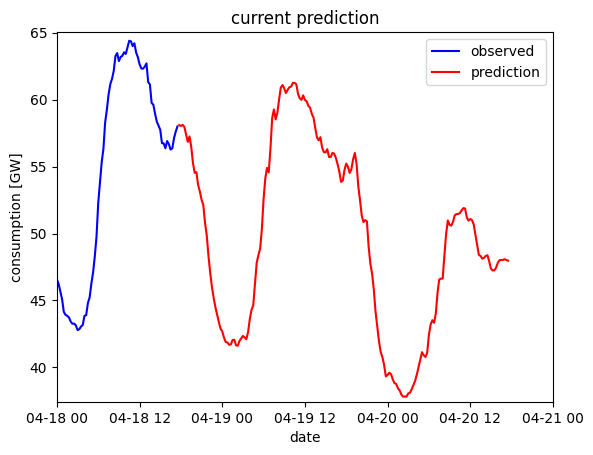

In [17]:
pipeline_v3b()

## Checking the pipepiline in different versions

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:525: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:528: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

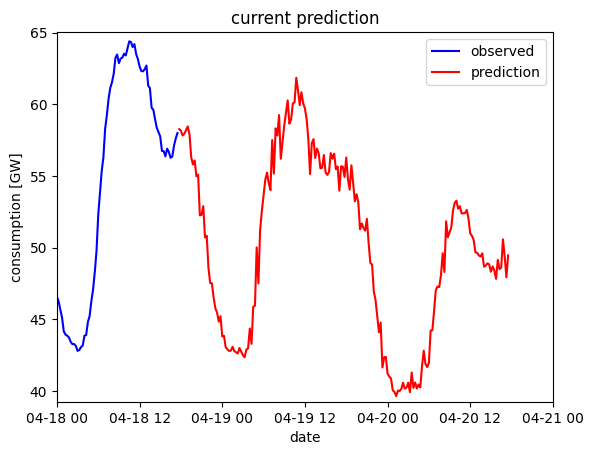

In [10]:
pipeline(newest=True,old=False,version='y_fraction1')

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:525: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:528: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

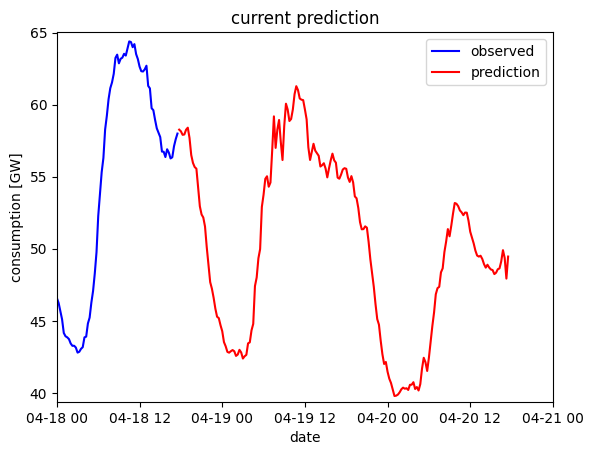

In [11]:
pipeline(newest=True,old=False,version='y_fraction1',mode='quadratic1')

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:525: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:528: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

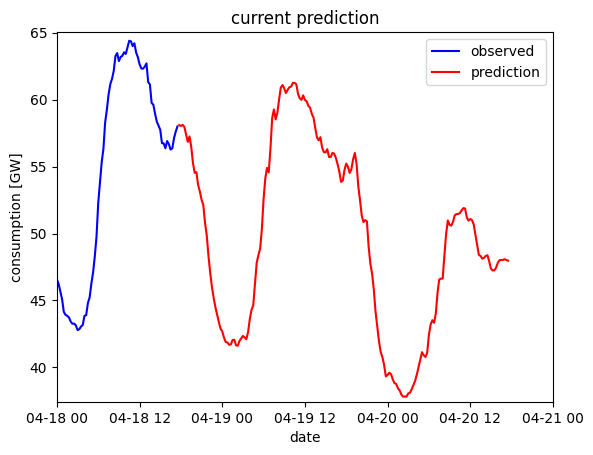

In [12]:
pipeline(newest=True,old=False,version='d_easter1',mode='quadratic1')

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:525: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:528: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

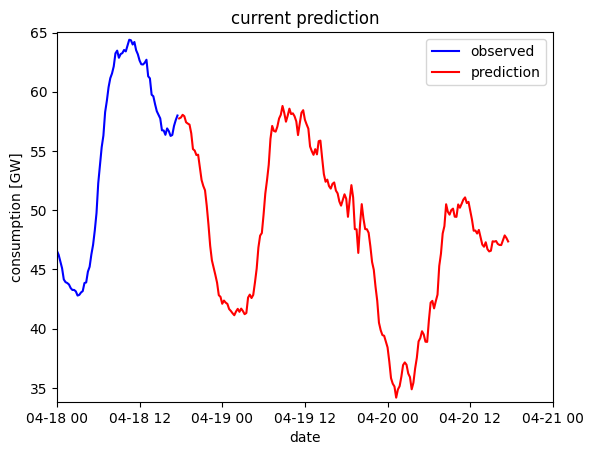

In [13]:
pipeline(newest=True,old=False,version='d_march1',mode='quadratic1')

Look good in general.
Now the versions. 

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:525: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:528: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

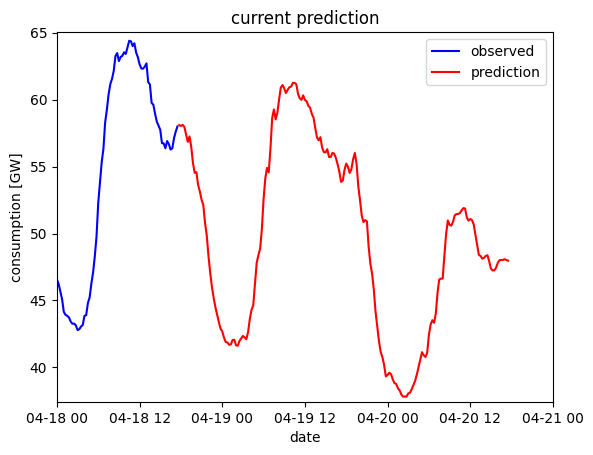

In [15]:
pipeline_v2()

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:525: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:528: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

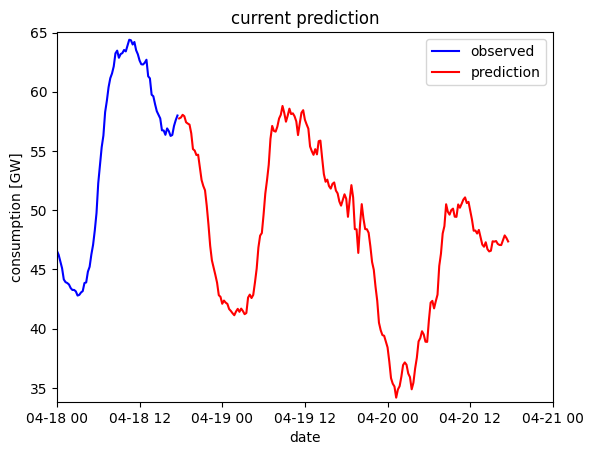

In [16]:
pipeline_v3()

Identical as above as it should be. 